# Proyecto Sistema de detección de enlaces spam

In [16]:
import pandas as pd

# Leer los datos desde la URL y mostrar las primeras filas
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
datos = pd.read_csv(url)
print(datos.head())


                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True


In [17]:
# Convertir la columna 'is_spam' de valores booleanos a 0 y 1
datos["is_spam"] = datos["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)


print(datos.head())


                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...        1
1                             https://www.hvper.com/        1
2                 https://briefingday.com/m/v4n3i4f3        1
3   https://briefingday.com/n/20200618/m#commentform        0
4                        https://briefingday.com/fan        1


In [18]:
print(datos.shape)
print(f"Spam: {len(datos.loc[datos.is_spam == 1])}")
print(f"No spam: {len(datos.loc[datos.is_spam == 0])}")


(2999, 2)
Spam: 696
No spam: 2303


In [19]:
datos = datos.drop_duplicates()
datos = datos.reset_index(inplace=False, drop=True)
print(datos.shape)


(2369, 2)


In [20]:
print(datos.shape)
print(f"Spam: {len(datos.loc[datos.is_spam == 1])}")
print(f"No spam: {len(datos.loc[datos.is_spam == 0])}")


(2369, 2)
Spam: 244
No spam: 2125


In [ ]:
#Preprocesar los enlaces
import regex as re  # Importamos la librería regex para expresiones regulares

# Función para preprocesar el texto
def preprocess_text(texto):
    # Eliminar cualquier carácter que no sea letra (a-z) o número (0-9)
    texto = re.sub(r'[^a-z0-9]', " ", texto)

    # Eliminar caracteres sueltos (letras solas entre espacios)
    texto = re.sub(r'\s+[a-zA-Z]\s+', " ", texto)
    texto = re.sub(r'\^[a-zA-Z]\s+', " ", texto)

    # Convertir a minúsculas y eliminar espacios múltiples
    texto = re.sub(r'\s+', " ", texto.lower())

    # Eliminar etiquetas HTML (como <tag>)
    texto = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", texto)

    # Retornar el texto como una lista de palabras
    return texto.split()

# Aplicar la función a la columna 'url'
datos["url"] = datos["url"].apply(preprocess_text)


print(datos.head())


                                                 url  is_spam
0  [https, briefingday, us8, list, manage, com, u...        1
1                           [https, www, hvper, com]        1
2                [https, briefingday, com, v4n3i4f3]        1
3   [https, briefingday, com, 20200618, commentform]        0
4                     [https, briefingday, com, fan]        1


In [24]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios de NLTK
download("wordnet")
download("stopwords")

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Obtener la lista de stopwords en inglés
stop_words = stopwords.words("english")

# Función para lematizar, eliminar stopwords y palabras cortas
def lemmatize_text(words, lemmatizer=lemmatizer):
    # Aplicar lematización a cada palabra
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # Eliminar stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Eliminar palabras de longitud menor o igual a 3
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

# Aplicar la función a la columna 'url' del DataFrame
datos["url"] = datos["url"].apply(lemmatize_text)


print(datos.head())


[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                              url  is_spam
0  [http, briefingday, list, manage, unsubscribe]        1
1                                   [http, hvper]        1
2                   [http, briefingday, v4n3i4f3]        1
3      [http, briefingday, 20200618, commentform]        0
4                             [http, briefingday]        1


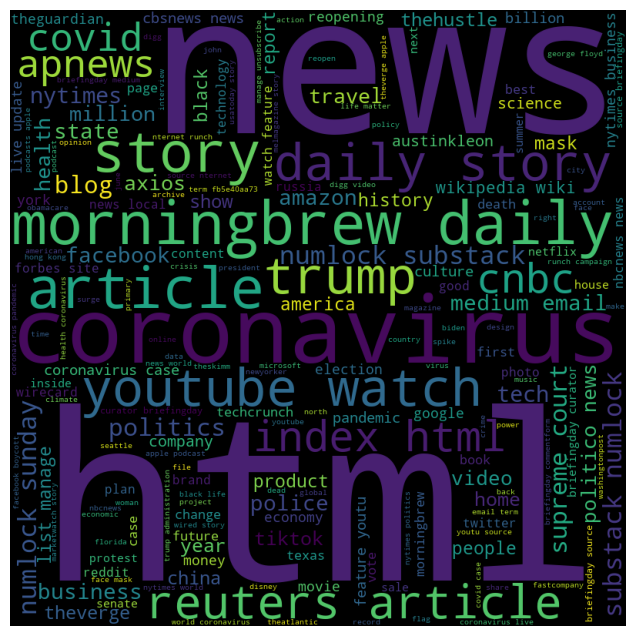

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="black",
    max_words=200,       # Mostrar máximo 200 palabras
    min_font_size=10,    # Tamaño mínimo de fuente más pequeño
    random_state=42
).generate(" ".join(datos["url"].apply(lambda x: " ".join(x))))

fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Obtener la lista de tokens de la columna 'url' y convertir cada lista en una cadena de texto
tokens_list = datos["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

# Crear el vectorizador TF-IDF con los parámetros indicados
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)

# Ajustar y transformar el texto para obtener la matriz TF-IDF
X = vectorizer.fit_transform(tokens_list).toarray()

# Variable objetivo: la columna 'is_spam'
y = datos["is_spam"]


In [29]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
#Construir una SVM
from sklearn.svm import SVC

# Crear el modelo SVM con kernel lineal
model = SVC(kernel="linear", random_state=42)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [31]:
# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)


print(y_pred)


[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [32]:
from sklearn.metrics import accuracy_score

# Calcular la exactitud (accuracy) del modelo en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9578


In [33]:
#Optimizar el modelo 
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Definimos los hiperparámetros para ajustar
hyperparams = {
    "C": [0.5, 1, 1.5, 10, 20],  # Eliminé -1 porque C debe ser > 0
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [3, 6, 9],
    "gamma": ['scale', 'auto'],
    "coef0": [0, 1, 2, 3],
    "shrinking": [True, False],
    "probability": [True, False],
    "class_weight": ['balanced', None],
    "verbose": [True, False],
    "max_iter": [-1, 1, 10, 15],
    "decision_function_shape": ['ovr', 'ovo'],
    "break_ties": [True, False]
}

# Inicializamos la búsqueda aleatoria
random_search = RandomizedSearchCV(
    model, 
    hyperparams, 
    n_iter=100, 
    scoring="accuracy", 
    cv=5, 
    random_state=42
)

# Mostrar el objeto creado
random_search


RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
                   n_iter=100,
                   param_distributions={'C': [0.5, 1, 1.5, 10, 20],
                                        'break_ties': [True, False],
                                        'class_weight': ['balanced', None],
                                        'coef0': [0, 1, 2, 3],
                                        'decision_function_shape': ['ovr',
                                                                    'ovo'],
                                        'degree': [3, 6, 9],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'max_iter': [-1, 1, 10, 15],
                                        'probability': [True, False],
                                        'shrinking': [True, False],
                                        'verbose': [True, False]},
                   random_state=42, scoring='accuracy')

In [35]:
# Ejecutar la búsqueda aleatoria para encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Best hyperparameters: {random_search.best_params_}")


[LibSVM]*
optimization finished, #iter = 510
obj = -5899.410946, rho = -0.999753
nSV = 376, nBSV = 294
Total nSV = 376
[LibSVM]*
optimization finished, #iter = 613
obj = -5626.988822, rho = -0.999430
nSV = 368, nBSV = 284
Total nSV = 368
[LibSVM]*
optimization finished, #iter = 548
obj = -5653.727414, rho = -0.999421
nSV = 355, nBSV = 282
Total nSV = 355
[LibSVM]*
optimization finished, #iter = 602
obj = -5819.243520, rho = -0.999380
nSV = 369, nBSV = 294
Total nSV = 369
[LibSVM]*
optimization finished, #iter = 603
obj = -5801.379133, rho = -0.999424
nSV = 377, nBSV = 297
Total nSV = 377


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -7.796374, rho = 0.811867
nSV = 16, nBSV = 15
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -7.796744, rho = 0.813187
nSV = 16, nBSV = 15
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -7.796329, rho = 0.811707
nSV = 16, nBSV = 15
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -7.796415, rho = 0.812014
nSV = 16, nBSV = 15
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -7.796437, rho = 0.812090
nSV = 16, nBSV = 15
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

.*
optimization finished, #iter = 1515
obj = -2063.327258, rho = -0.325599
nSV = 1516, nBSV = 1515
Total nSV = 1516
[LibSVM]

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

.*
optimization finished, #iter = 1515
obj = -2013.817526, rho = -0.248208
nSV = 1516, nBSV = 1515
Total nSV = 1516
[LibSVM]

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

.*
optimization finished, #iter = 1515
obj = -2023.540645, rho = -0.264823
nSV = 1516, nBSV = 1515
Total nSV = 1516
[LibSVM]

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

.*
optimization finished, #iter = 1515
obj = -2040.659275, rho = -0.239979
nSV = 1516, nBSV = 1515
Total nSV = 1516
[LibSVM]

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

.*
optimization finished, #iter = 1515
obj = -2040.022204, rho = -0.265943
nSV = 1516, nBSV = 1515
Total nSV = 1516


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.011336
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.011336
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.011336
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.011336
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.014212
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.013793
nSV = 20, nBSV = 20
Total nSV = 20
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.662077, rho = -0.010392
nSV = 20, nBSV = 20
Total nSV = 

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -199.816006, rho = -0.014267
nSV = 20, nBSV = 20
Total nSV = 20
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.910348, rho = -0.623733
nSV = 2, nBSV = 1
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.910348, rho = -0.623733
nSV = 2, nBSV = 1
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.910348, rho = -0.623733
nSV = 2, nBSV = 1
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.910348, rho = -0.623733
nSV = 2, nBSV = 1
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.910348, rho = -0.623733
nSV = 2, nBSV = 1
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.910348, rho = 0.623733
nSV = 2, nBSV = 1
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_it

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM].*
optimization finished, #iter = 1107
obj = -372.184014, rho = 0.116548
nSV = 579, nBSV = 356
Total nSV = 579
.*
optimization finished, #iter = 1049
obj = -384.428767, rho = 0.053040
nSV = 596, nBSV = 385
Total nSV = 596
.*
optimization finished, #iter = 1225
obj = -370.989042, rho = 0.197993
nSV = 579, nBSV = 354
Total nSV = 579
.*
optimization finished, #iter = 1119
obj = -363.832990, rho = 0.224348
nSV = 581, nBSV = 353
Total nSV = 581
.*
optimization finished, #iter = 1252
obj = -353.051296, rho = 0.206818
nSV = 573, nBSV = 330
Total nSV = 573
.*
optimization finished, #iter = 1333
obj = -461.646445, rho = -0.054297
nSV = 702, nBSV = 457
Total nSV = 702
[LibSVM]*
optimization finished, #iter = 998
obj = -336.368221, rho = 0.361939
nSV = 525, nBSV = 322
Total nSV = 525
.*
optimization finished, #iter = 1107
obj = -324.906624, rho = 0.329025
nSV = 532, nBSV = 309
Total nSV = 532
.*
optimization finished, #iter = 1105
obj = -351.700576, rho = 0.299562
nSV = 548, nBSV = 336
To

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -113.962309, rho = 0.620183
nSV = 12, nBSV = 5
Total nSV = 12
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -114.029776, rho = 0.656064
nSV = 12, nBSV = 5
Total nSV = 12
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -106.461150, rho = 0.355801
nSV = 15, nBSV = 4
Total nSV = 15
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -127.977528, rho = 1.042400
nSV = 11, nBSV = 6
Total nSV = 11
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -131.171612, rho = 0.582517
nSV = 14, nBSV = 5
Total nSV = 14
[LibSVM]*
optimization finished, #iter = 361
obj = -2171.593916, rho = 1.000456
nSV = 303, nBSV = 211
Total nSV = 303
*
optimization finished, #iter = 357
obj = -2177.164659, rho = 1.000394
nSV = 300, nBSV = 203
Total nSV = 300


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


*
optimization finished, #iter = 370
obj = -2215.093643, rho = 1.000422
nSV = 304, nBSV = 210
Total nSV = 304
*
optimization finished, #iter = 353
obj = -2143.498833, rho = 1.000390
nSV = 304, nBSV = 204
Total nSV = 304
*
optimization finished, #iter = 319
obj = -2042.620376, rho = 1.000442
nSV = 287, nBSV = 199
Total nSV = 287
*
optimization finished, #iter = 547
obj = -2639.882332, rho = -0.999623
nSV = 375, nBSV = 255
Total nSV = 375
[LibSVM]*
optimization finished, #iter = 321
obj = -2051.579839, rho = 1.000403
nSV = 305, nBSV = 201
Total nSV = 305
*
optimization finished, #iter = 337
obj = -2056.024773, rho = 1.000465
nSV = 290, nBSV = 197
Total nSV = 290
*
optimization finished, #iter = 337
obj = -2156.460567, rho = 1.000412
nSV = 300, nBSV = 200
Total nSV = 300
*
optimization finished, #iter = 331
obj = -2033.286046, rho = 1.000390
nSV = 289, nBSV = 202
Total nSV = 289
*
optimization finished, #iter = 287
obj = -1968.017040, rho = 1.000425
nSV = 278, nBSV = 193
Total nSV = 278
*

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -44.998953, rho = 0.000052
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -44.998930, rho = 0.000045
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -44.998953, rho = 0.000048
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -44.998960, rho = 0.000039
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -44.998521, rho = 0.000016
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -141.490037, rho = 0.000000
nSV = 16, nBSV = 14
Total nSV = 16
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -141.490037, rho = 0.000000
nSV = 16, nB

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_va


optimization finished, #iter = 15
obj = -141.491203, rho = 0.000000
nSV = 16, nBSV = 14
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -146.267157, rho = -0.033497
nSV = 20, nBSV = 14
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -146.267157, rho = -0.033497
nSV = 20, nBSV = 14
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -141.491810, rho = 0.000000
nSV = 16, nBSV = 14
Total nSV = 16
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -146.267157, rho = -0.033497
nSV = 20, nBSV = 14
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -139.076197, rho = -0.053796
nSV = 27, nBSV = 12
Total nSV = 27
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -141.491810, rho = 0.000000
nSV = 16, nBSV = 14
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -598.648310, rho = -0.020785
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -598.648310, rho = -0.020785
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -599.264026, rho = -0.019817
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -598.648310, rho = -0.022759
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -598.786330, rho = -0.017070
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -599.264026, rho = -0.027586
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -598.648310, rho = -0.022672
nSV = 30, nBSV = 30
Total nSV = 

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -1.875000, rho = 0.187493
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -1.875000, rho = 0.187493
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -1.875000, rho = 0.187493
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -1.875000, rho = 0.187493
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -1.875000, rho = 0.168161
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -17.512245, rho = 0.062160
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -17.512245, rho = 0.062160
nSV = 2, nBSV = 2
Total nSV = 2
[Lib

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -119.833810, rho = 0.750000
nSV = 13, nBSV = 5
Total nSV = 13
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -119.833810, rho = 0.750000
nSV = 13, nBSV = 5
Total nSV = 13
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -119.833810, rho = 0.750000
nSV = 13, nBSV = 5
Total nSV = 13
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -120.162116, rho = 0.787372
nSV = 13, nBSV = 6
Total nSV = 13
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -120.118707, rho = 1.000000
nSV = 12, nBSV = 6
Total nSV = 12
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -120.136044, rho = 1.000000
nSV = 13, nBSV = 6
Total nSV = 13
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -80.162070, rho = 0.785458
nSV = 13, nBSV = 4
Total nSV = 13
WARN: libsvm Solver 

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termina

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.380003, rho = -0.999854
nSV = 24, nBSV = 15
Total nSV = 24
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.383570, rho = -0.999911
nSV = 25, nBSV = 15
Total nSV = 25
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.380558, rho = -0.999860
nSV = 25, nBSV = 15
Total nSV = 25
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.385129, rho = -0.999909
nSV = 23, nBSV = 15
Total nSV = 23
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.375117, rho = -0.999948
nSV = 25, nBSV = 15
Total nSV = 25
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.381944, rho = 0.999946
nSV = 18, nBSV = 15
Total nSV = 18
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -336.380985, rho = -0.999913
nSV = 24, nBSV = 15
Total nSV = 2

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


*
optimization finished, #iter = 367
obj = -97.859340, rho = 1.000374
nSV = 283, nBSV = 192
Total nSV = 283
*
optimization finished, #iter = 423
obj = -98.347603, rho = 1.000482
nSV = 292, nBSV = 185
Total nSV = 292
*
optimization finished, #iter = 441
obj = -100.513282, rho = 1.000444
nSV = 304, nBSV = 188
Total nSV = 304
*
optimization finished, #iter = 404
obj = -97.035644, rho = 1.000371
nSV = 284, nBSV = 180
Total nSV = 284
*
optimization finished, #iter = 367
obj = -92.392691, rho = 1.000411
nSV = 266, nBSV = 174
Total nSV = 266
*
optimization finished, #iter = 751
obj = -120.026880, rho = -0.999448
nSV = 364, nBSV = 230
Total nSV = 364
[LibSVM]*
optimization finished, #iter = 365
obj = -89.946859, rho = 1.000438
nSV = 281, nBSV = 175
Total nSV = 281
*
optimization finished, #iter = 389
obj = -91.171522, rho = 1.000420
nSV = 288, nBSV = 175
Total nSV = 288
*
optimization finished, #iter = 382
obj = -98.585863, rho = 1.000437
nSV = 292, nBSV = 185
Total nSV = 292
*
optimization fi

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

.*
optimization finished, #iter = 1333
obj = -461.646445, rho = -0.054297
nSV = 702, nBSV = 457
Total nSV = 702
[LibSVM].*
optimization finished, #iter = 1285
obj = -415.329131, rho = -0.303259
nSV = 642, nBSV = 411
Total nSV = 642
[LibSVM].*
optimization finished, #iter = 1290
obj = -439.585017, rho = -0.236630
nSV = 662, nBSV = 442
Total nSV = 662
[LibSVM].*
optimization finished, #iter = 1297
obj = -436.746612, rho = -0.207769
nSV = 653, nBSV = 433
Total nSV = 653
[LibSVM].*
optimization finished, #iter = 1277
obj = -421.713460, rho = -0.226624
nSV = 640, nBSV = 410
Total nSV = 640
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -53.962309, rho = 0.620183
nSV = 12, nBSV = 5
Total nSV = 12
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -54.029776, rho = 0.656064
nSV = 12, nBSV = 5
Total nSV = 12
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -66.461150, rho = 0.355801
nSV 

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

*
optimization finished, #iter = 164
obj = -3279.999647, rho = -1.000000
nSV = 328, nBSV = 328
Total nSV = 328
[LibSVM]*
optimization finished, #iter = 164
obj = -3279.999673, rho = -1.000000
nSV = 328, nBSV = 328
Total nSV = 328
[LibSVM]*
optimization finished, #iter = 164
obj = -3279.999703, rho = -1.000000
nSV = 328, nBSV = 328
Total nSV = 328
[LibSVM]*
optimization finished, #iter = 164
obj = -3279.999716, rho = -1.000000
nSV = 328, nBSV = 328
Total nSV = 328


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832219, rho = -0.186513
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832219, rho = -0.186513
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832219, rho = -0.186513
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832219, rho = -0.186513
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832219, rho = -0.205180
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832219, rho = -0.202850
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.632705, rho = -0.177679
nSV = 30, nBSV = 30
Total nSV = 30
WARN

/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metr

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.629947, rho = -0.186323
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.629947, rho = -0.186323
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832418, rho = -0.174345
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.629947, rho = -0.186659
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.704106, rho = -0.160695
nSV = 30, nBSV = 30
Total nSV = 30
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.832418, rho = -0.205310
nSV = 30, nBSV = 30
Total nSV = 30


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.000000, rho = 1.000000
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -2.878084, rho = 0.000000
nSV = 2, nBSV = 0
Total nSV = 2
WARN: libsvm Solver reached max_iter
optimizat

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -15.840375, rho = 0.967376
nSV = 16, nBSV = 10
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -16.197382, rho = 0.825084
nSV = 16, nBSV = 10
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -15.789772, rho = 0.985767
nSV = 16, nBSV = 10
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -15.885525, rho = 0.950676
nSV = 16, nBSV = 10
Total nSV = 16
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -12.248742, rho = 0.913143
nSV = 16, nBSV = 8
Total nSV = 16


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -33.596351, rho = 0.151832
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -33.619120, rho = 0.150363
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -33.593621, rho = 0.152010
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -33.598878, rho = 0.151668
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -33.600190, rho = 0.139463
nSV = 2, nBSV = 2
Total nSV = 2


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminat

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.018346, rho = 1.000004
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.018346, rho = 1.000004
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.018346, rho = 1.000004
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.018346, rho = 1.000004
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.018346, rho = 1.000004
nSV = 2, nBSV = 0
Total nSV = 2
[LibSVM].*
optimization finished, #iter = 1346
obj = -1680.120387, rho = 1.000634
nSV = 479, nBSV = 73
Total nSV = 479


/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

.*
optimization finished, #iter = 1550
obj = -1560.134916, rho = 1.000640
nSV = 477, nBSV = 65
Total nSV = 477
.*
optimization finished, #iter = 1652
obj = -1560.138572, rho = 1.000651
nSV = 524, nBSV = 68
Total nSV = 524
.*
optimization finished, #iter = 1411
obj = -1520.133654, rho = 1.000637
nSV = 489, nBSV = 70
Total nSV = 489
.*
optimization finished, #iter = 1352
obj = -1400.128707, rho = 1.000608
nSV = 458, nBSV = 62
Total nSV = 458
..*
optimization finished, #iter = 2842
obj = -1960.155928, rho = -0.999359
nSV = 618, nBSV = 87
Total nSV = 618
[LibSVM].*
optimization finished, #iter = 1423
obj = -1360.141111, rho = 1.000676
nSV = 458, nBSV = 61
Total nSV = 458
.*
optimization finished, #iter = 1652
obj = -1240.148643, rho = 1.000680
nSV = 460, nBSV = 52
Total nSV = 460
.*
optimization finished, #iter = 1538
obj = -1400.153358, rho = 1.000664
nSV = 455, nBSV = 60
Total nSV = 455
.*
optimization finished, #iter = 1418
obj = -1240.142048, rho = 1.000658
nSV = 444, nBSV = 53
Total n

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated

WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -19.329401, rho = -0.348824
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -18.519020, rho = -0.373448
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -18.815892, rho = -0.321527
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -19.329401, rho = -0.405475
nSV = 20, nBSV = 20
Total nSV = 20
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -18.519790, rho = -0.372647
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -18.519790, rho = -0.372647
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10
obj = -19.329673, rho = -0.348689
nSV = 20, nBSV = 20
Total nSV = 20
WARN: libsvm

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.999540, rho = -0.000690
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.999540, rho = -0.000690
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.999540, rho = -0.000690
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.999540, rho = -0.000690
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -14.999540, rho = -0.000713
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.960145, rho = 0.002948
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.959212, rho = 0.002531
n

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver termin

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.328876, rho = -0.405701
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.333587, rho = -0.403667
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.328305, rho = -0.405946
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.329401, rho = -0.405475
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = -29.329673, rho = -0.410620
nSV = 30, nBSV = 30
Total nSV = 30
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.875000, rho = 0.062498
nSV = 2, nBSV = 2
Total nSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -0.875000, rho = 0.062498
nSV = 2,

/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated

Best hyperparameters: {'verbose': False, 'shrinking': True, 'probability': True, 'max_iter': -1, 'kernel': 'linear', 'gamma': 'auto', 'degree': 6, 'decision_function_shape': 'ovr', 'coef0': 0, 'class_weight': None, 'break_ties': False, 'C': 1.5}


In [36]:
from sklearn.svm import SVC

# Crear el modelo SVM con los mejores hiperparámetros encontrados
model_optimized = SVC(
    verbose=False,
    shrinking=False,
    probability=False,
    max_iter=-1,
    kernel='rbf',
    gamma='scale',
    degree=3,
    decision_function_shape='ovr',
    coef0=2,
    class_weight=None,
    break_ties=False,
    C=10
)

# Entrenar el modelo optimizado con los datos de entrenamiento
model_optimized.fit(X_train, y_train)


SVC(C=10, coef0=2, shrinking=False)

In [37]:
# Predecir etiquetas en el conjunto de prueba usando el modelo optimizado
y_pred = model_optimized.predict(X_test)


print(y_pred)


[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [38]:
from sklearn.metrics import accuracy_score

# Calcular la precisión (accuracy) del modelo optimizado en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9557


El modelo SVM entrenado logró una precisión (accuracy) del 95.57%, lo que indica que clasificó correctamente la gran mayoría de los ejemplos en el conjunto de prueba. Este alto nivel de exactitud sugiere que el modelo es eficaz para distinguir entre URLs spam y no spam en este dataset.

In [39]:
from pickle import dump

# Guardar el modelo entrenado en un archivo
dump(model, open("../models/svc_model.sav", "wb"))
